In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
rawdata1 = pd.read_excel("../dataset/tourdata2017_1.xlsx")
rawdata2 = pd.read_excel("../dataset/tourdata2017_2.xlsx")
rawdata3 = pd.read_excel("../dataset/tourdata2017_3.xlsx")

## 1. 분석 데이터 생성

### 1-1. 데이터 정제

In [3]:
# 컬럼명 통일 (공백제거, 소문자 맞춤)

rawdata1.rename(columns=lambda x: x.strip().lower(), inplace=True)
rawdata2.rename(columns=lambda x: x.strip().lower(), inplace=True)
rawdata3.rename(columns=lambda x: x.strip().lower(), inplace=True)

In [4]:
# m_id 빈 값 지우기
# m_id 값이 null이면 다른 컬럼의 value도 null이기 때문에 해당 열을 삭제

rawdata2 = rawdata2.dropna(subset=["m_id"])
rawdata3 = rawdata3.dropna(subset=["m_id"])

In [5]:
#국내여행자만 선택해서 보기

rawdata2 = rawdata2[rawdata2["type1"] == 1]
rawdata3 = rawdata3[rawdata3["type1"] == 1]

In [6]:
# 필요한 컬럼만 선택해서 보기
# 분석에 불필요한 컬럼을 제거

rawdata1 = rawdata1.drop(['sr_type','ara_size', 'school1','school2','occ0','occ2','marry','fac','inc1_1','inc2_1','wt'], axis = 1)

In [7]:
# 필요한 컬럼만 선택해서 보기
# 분석에 불필요한 컬럼을 제거

rawdata2 = rawdata2.drop(['m_id','type2','q2_a','q2_a_1','q2_a_2','q2_b','q2_b_1','q2_b_1','q2_b_2','q2_c_1','q2_c_2','q2_1_1',
                          'q5_2_1','q5_2_2','q5_2_3','q5_2_4','q5_2_5','q5_2_6',
                          'q7_1','q7_3_1','q7_3_2','q7_3_3','q7_3_4','q7_3_5','q7_3_6','q7_3_7','q7_3_8','q7_3_9','q7_3_10',
                          'q2_1_2','q2_1_3','q2_1_4','q2_1_5','q4_1_a','q4_1_b','q9_2','wt'], axis = 1)

In [8]:
# 필요한 컬럼만 선택해서 보기
# 분석에 불필요한 컬럼을 제거

rawdata3 = rawdata3.drop(['m_id','type2','q6_1_1','q6_1_2','q6_1_3','q6_1_4','q6_1_5','q6_1_6','q6_1_7','q6_1_8',
                          'q6_5_1a','q6_5_2a','q6_5_3a','q6_5_4a','q6_5_5a','q6_5_6a','q6_5_7a','q6_5_8a','q6_5_9a','q6_5_10a',
                          'q6_5_11a','q6_5_12a','q6_5_13a','q7_2','wt'], axis = 1)

### 1-2. 1차 join = 단위여행 + 방문지

In [9]:
# 1차 join = 같은 응답자의 단위여행 데이터와, 방문지 데이터를 합친다.
# hid,pid,month가 같으면 해당데이터는 동일인물임

joinKey = ["hid","pid","month"]

In [10]:
firstmerge = pd.merge(rawdata2, rawdata3, left_on=joinKey, right_on=joinKey, how="left")

In [11]:
# 나이를 세대별로 구분하기 위해 새로운 컬럼 생성

rawdata1["age_group"] = np.where(rawdata1["age"]>0, (((rawdata1["age"]/10).astype(int))*10) , 0)

In [12]:
# 응답자 20대 추출

rawdata1 = rawdata1[rawdata1.age_group==20]

### 1-3. 2차 join = 응답자 + 1차 join

In [13]:
# 2차 join 데이터 = 같은 응답자의 응답자 정보와 1차 join 데이터를 합친다.
# hid,pid가 같으면 해당데이터는 동일인물임

joinKey2 = ["hid","pid"]

In [14]:
secondmerge = pd.merge(rawdata1, firstmerge, left_on=joinKey2, right_on=joinKey2, how="left")

In [15]:
# 총지출비용 컬럼이 null값인 데이터를 삭제

secondmerge = secondmerge.dropna(subset=["q7"])

In [16]:
secondmerge = secondmerge.reset_index(drop = True)

### 2-1. 직업 기준 생성

In [17]:
# 직업을 분류를 명확히하기 위해 대학생,직장인,무직,군인,무응답으로 재설정

jobCodeList = []

for i in range(0,len(secondmerge)):
    jobCode = 123
    job = secondmerge["occ1"][i]
    
    if ((job == 14) | (job == 15)):
        #대학생
        jobCode = 1
    elif job < 10:
        #직장인
        jobCode = 2
    elif job == 16:
        #무직
        jobCode = 3
    elif job == 10:
        #군인
        jobCode = 4
    else:
        jobCode = 5
    jobCodeList.append(jobCode)

In [18]:
columnName = "job_group"
tempDF = pd.DataFrame(jobCodeList, columns=[columnName])
secondmerge = pd.concat([secondmerge, tempDF], axis=1)

### 3-1. 만족도 기준 생성

In [19]:
# 항목별 만족도 컬럼이 null값인 데이터를 삭제
# 기존 만족도 데이터는 단편적이며 데이터를 분류하는데 어려움이 있기 때문에 새로운 만족도 기준을 생성

satisfaction = secondmerge.dropna(subset=["q10_1"]).reset_index(drop = True)

In [20]:
# 항목별 만족도에서 9.경험해보지 못함 -> 0으로 바꿈

satisfaction.loc[:,"q10_1":"q10_12"] = np.where(satisfaction.loc[:,"q10_1":"q10_12"] == 9,0,satisfaction.loc[:,"q10_1":"q10_12"])

In [21]:
# 항복별 만족도의 평균을 구한후 소수점 반올림후 2배하여 새로운 기준을 생성

tempList = []

for i in range(0,len(satisfaction)):
    zeroCount = 0
    for j in satisfaction.loc[i,"q10_1":"q10_12"]:
        if j==0:
            zeroCount += 1
    
    # 항목별 만족도, 전반적 만족도, 재방문의향, 추천의향에 가중치를 설정
    tempList.append(
     (round((math.pow((sum(satisfaction.loc[i,"q10_1":"q10_12"]) / (12-zeroCount)), 2)) * 10) / 10) * 1.2
     + (math.pow((satisfaction.loc[i,"q6_7"]), 2) * 1.6)
     + (math.pow((satisfaction.loc[i,"q6_8"]), 2) * 0.8)
     + (math.pow((satisfaction.loc[i,"q6_9"]), 2) * 0.4))

In [22]:
colName = "q10_grade"
tempDF = pd.DataFrame(tempList, columns=[colName])
result01 = pd.concat([satisfaction, tempDF], axis=1)

### 3-2. 숙박시설 컬럼 (망함 ㅠㅠ)

In [23]:
# result01["q6_5_1"] = result01["q6_5_1"].fillna(0)
# result01["q6_5_2"] =result01["q6_5_2"].fillna(0)
# result01["q6_5_3"] =result01["q6_5_3"].fillna(0)
# result01["q6_5_4"] =result01["q6_5_4"].fillna(0)
# result01["q6_5_5"] =result01["q6_5_5"].fillna(0)
# result01["q6_5_6"] =result01["q6_5_6"].fillna(0)
# result01["q6_5_7"] =result01["q6_5_7"].fillna(0)
# result01["q6_5_8"] =result01["q6_5_8"].fillna(0)
# result01["q6_5_9"] =result01["q6_5_9"].fillna(0)
# result01["q6_5_10"] =result01["q6_5_10"].fillna(0)
# result01["q6_5_11"] =result01["q6_5_11"].fillna(0)
# result01["q6_5_12"] =result01["q6_5_12"].fillna(0)
# result01["q6_5_13"] =result01["q6_5_13"].fillna(0)

In [24]:
# q6_List = []
# for i in range(0,len(result01)):
#     q6_List.append(sum(result01.loc[i,"q6_5_1":"q6_5_13"]))

In [25]:
# colName = "숙박시설"
# tempDF = pd.DataFrame(q6_List, columns=[colName])
# tempDF["숙박시설"] = tempDF["숙박시설"].astype(int)
# result01 = pd.concat([result01, tempDF], axis=1)

### 3-3. 일별 지출비용 등급

In [26]:
# 지출비용을 이용한 분류를 명확히 하기 위해 지출비용을 5단계로 설정
# 1 : 3만원 이하 
# 2 : 6만원 이하
# 3 : 10만원 이하
# 4 : 20만원 이하
# 5 : 이외 전부

tempList = []

for i in range(0,len(satisfaction)):
    q7 = result01.loc[i,"q7"]
    day = result01.loc[i,"q6_2"]
    temp = q7 / day
    
    if (temp <= 30000):
        grade = 1
    elif (temp <= 60000):
        grade = 2
    elif (temp <= 100000):
        grade = 3
    elif (temp <= 200000):
        grade = 4
    elif (temp > 200000):
        grade = 5
    
    tempList.append(grade)

In [27]:
colName = "q7_grade"
tempDF = pd.DataFrame(tempList, columns=[colName])
result01 = pd.concat([result01, tempDF], axis=1)

In [28]:
result01

,hid,pid,sex,age,sido,occ1,age_group,type1_x,month,q1,...,q6_6_18,q6_6_19,q6_6_20,q6_6_21,q6_7,q6_8,q6_9,job_group,q10_grade,q7_grade
0,10003,1000303,2,28,1,16,20,1.0,4.0,2.0,...,NaN,NaN,NaN,NaN,4.0,4.0,3.0,3,61.20,4
1,10019,1001904,2,23,1,14,20,1.0,4.0,2.0,...,NaN,NaN,NaN,NaN,4.0,4.0,4.0,1,64.00,3
2,10019,1001904,2,23,1,14,20,1.0,8.0,2.0,...,NaN,NaN,NaN,NaN,4.0,4.0,4.0,1,64.00,3
3,10031,1003105,1,21,1,14,20,1.0,3.0,2.0,...,NaN,NaN,NaN,NaN,5.0,5.0,5.0,1,89.20,2
4,10031,1003105,1,21,1,14,20,1.0,10.0,2.0,...,NaN,NaN,NaN,NaN,5.0,4.0,5.0,1,86.08,2
5,10031,1003105,1,21,1,14,20,1.0,10.0,2.0,...,NaN,NaN,NaN,NaN,4.0,4.0,4.0,1,68.08,2
6,10031,1003105,1,21,1,14,20,1.0,10.0,2.0,...,NaN,NaN,NaN,NaN,5.0,4.0,5.0,1,84.52,2
7,10031,1003105,1,21,1,14,20,1.0,10.0,2.0,...,NaN,NaN,NaN,NaN,4.0,4.0,4.0,1,66.52,2
8,10045,1004503,2,22,1,14,20,1.0,4.0,2.0,...,NaN,NaN,NaN,NaN,4.0,5.0,4.0,1,68.08,3
9,10045,1004503,2,22,1,14,20,1.0,6.0,2.0,...,NaN,NaN,NaN,NaN,4.0,4.0,4.0,1,62.44,3


In [29]:
result01.to_csv("../dataset/result_join.csv", index=False)

## 2. 데이터 모델링

### 2-1. 상관관계 분석

In [30]:
corrGroupKey = ["hid","pid",'month','age',"job_group" ]

In [31]:
tmp = result01.groupby(corrGroupKey).sum().reset_index(drop=False)

In [32]:
columnList = ['q10_grade','hid', 'pid', 'month', 'age', 'sex', 'sido', 'occ1',  
              'age_group', 'type1_x','type1_y', 'q1', 'q3', 'q4_a', 'q5_1', 'q7', 'q8', 'q8_1', 'q8_2', 'q8_3', 'q8_4', 
              'q8_5', 'q8_6', 'q8_7', 'q10_1', 'q10_2', 'q10_3', 'q10_4', 'q10_5', 'q10_6', 'q10_7', 'q10_8', 
              'q10_9', 'q10_10', 'q10_11', 'q10_12', 'q6_1', 'q6_2', 'q6_3_a', 'q6_3_b', 'q6_3_c', 'q6_4', 'q6_5_1', 'q6_5_2', 
              'q6_5_3', 'q6_5_4', 'q6_5_5', 'q6_5_6', 'q6_5_7', 'q6_5_8', 'q6_5_9', 'q6_5_10', 'q6_5_11', 'q6_5_12', 'q6_5_13', 
              'q6_6_1', 'q6_6_2', 'q6_6_3', 'q6_6_4', 'q6_6_5', 'q6_6_6', 'q6_6_7', 'q6_6_8', 'q6_6_9', 'q6_6_10', 
              'q6_6_11', 'q6_6_12', 'q6_6_13', 'q6_6_14', 'q6_6_15', 'q6_6_16', 'q6_6_17', 'q6_6_18', 'q6_6_19', 
              'q6_6_20', 'q6_6_21', 'q6_7', 'q6_8', 'q6_9']

In [33]:
tmp = tmp[columnList]

In [34]:
corrDF999 = tmp.corr()

In [35]:
corrDF999

,q10_grade,hid,pid,month,age,sex,sido,occ1,age_group,type1_x,...,q6_6_15,q6_6_16,q6_6_17,q6_6_18,q6_6_19,q6_6_20,q6_6_21,q6_7,q6_8,q6_9
q10_grade,1.000000,0.029657,0.028846,0.015492,0.092151,0.908744,0.899973,0.803357,0.983236,0.983236,...,-0.013952,0.015025,0.156450,0.113497,0.079809,0.045742,0.101527,0.995513,0.993762,0.994018
hid,0.029657,1.000000,0.978469,0.049624,-0.034502,0.037439,0.093005,0.072488,0.023511,0.023511,...,-0.010009,-0.018878,-0.002471,-0.014017,0.072504,0.105764,0.098794,0.024999,0.024070,0.024020
pid,0.028846,0.978469,1.000000,0.045290,-0.055726,0.030525,0.099414,0.080296,0.023440,0.023440,...,-0.011934,-0.015746,0.003014,-0.012733,0.076710,0.104775,0.103793,0.024951,0.023783,0.023438
month,0.015492,0.049624,0.045290,1.000000,-0.021127,0.016418,0.012802,0.004324,0.013563,0.013563,...,0.018693,-0.017495,-0.118221,0.001015,-0.036219,-0.085987,-0.063707,0.011181,0.011640,0.012231
age,0.092151,-0.034502,-0.055726,-0.021127,1.000000,0.044735,0.064695,-0.076685,0.076608,0.076608,...,-0.065653,-0.011086,0.086420,0.032479,-0.034368,-0.022936,-0.001968,0.086076,0.083145,0.086233
sex,0.908744,0.037439,0.030525,0.016418,0.044735,1.000000,0.799290,0.813947,0.912952,0.912952,...,-0.030875,-0.002528,0.150777,0.075783,0.037891,0.086612,0.131207,0.908396,0.915041,0.912728
sido,0.899973,0.093005,0.099414,0.012802,0.064695,0.799290,1.000000,0.714402,0.930371,0.930371,...,-0.021570,-0.016672,0.095528,0.084455,0.115472,0.045520,0.078295,0.919270,0.919591,0.919351
occ1,0.803357,0.072488,0.080296,0.004324,-0.076685,0.813947,0.714402,1.000000,0.799922,0.799922,...,0.019461,0.037225,0.183303,0.017153,0.123206,0.102503,0.179054,0.799020,0.804382,0.802323
age_group,0.983236,0.023511,0.023440,0.013563,0.076608,0.912952,0.930371,0.799922,1.000000,1.000000,...,-0.008563,0.011512,0.122023,0.117113,0.073111,0.056670,0.102740,0.994263,0.994196,0.993582
type1_x,0.983236,0.023511,0.023440,0.013563,0.076608,0.912952,0.930371,0.799922,1.000000,1.000000,...,-0.008563,0.011512,0.122023,0.117113,0.073111,0.056670,0.102740,0.994263,0.994196,0.993582


In [36]:
# corrDF999.to_csv("./dataset/result_Corr.csv")

## K-Means Clustering

In [37]:
import pandas as pd
# K-Means 라이브러리
from sklearn.cluster import KMeans
# 시각화 라이브러리
import matplotlib.pyplot as plt

# Only needed if you want to display your plots inline if using Notebook
# change inline to auto if you have Spyder installed
%matplotlib inline

In [38]:
### 특성정보 분리
# "q1", #당일/숙박여행 여부
# "q3", #여행 주 목적
# "q4_a", #정보획득지
# "q5_1", #여행 일행수
# "q8", #사전예약
# "sex",
# "job_group",
# "q7_grade",
# "q6_3_a", #여행지 선택이유
# "q6_3_b",
# "q6_3_c",
# "q6_4" # 주요 이동수단
            
features = result01[["q1","q3","q4_a","q5_1","q6_4","q7_grade", "q8","q10_grade"]]

In [60]:
### 모델선언 및 feature 만 활용하여 자율학습
model = KMeans(n_clusters=4, algorithm="auto")
model.fit(features)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [61]:
predict = pd.DataFrame(model.predict(features))
predict.columns=["cluster"]

In [62]:
testDF = pd.concat([result01, predict],  axis=1)

In [63]:
testDF

,hid,pid,sex,age,sido,occ1,age_group,type1_x,month,q1,...,q6_6_19,q6_6_20,q6_6_21,q6_7,q6_8,q6_9,job_group,q10_grade,q7_grade,cluster
0,10003,1000303,2,28,1,16,20,1.0,4.0,2.0,...,NaN,NaN,NaN,4.0,4.0,3.0,3,61.20,4,0
1,10019,1001904,2,23,1,14,20,1.0,4.0,2.0,...,NaN,NaN,NaN,4.0,4.0,4.0,1,64.00,3,0
2,10019,1001904,2,23,1,14,20,1.0,8.0,2.0,...,NaN,NaN,NaN,4.0,4.0,4.0,1,64.00,3,0
3,10031,1003105,1,21,1,14,20,1.0,3.0,2.0,...,NaN,NaN,NaN,5.0,5.0,5.0,1,89.20,2,3
4,10031,1003105,1,21,1,14,20,1.0,10.0,2.0,...,NaN,NaN,NaN,5.0,4.0,5.0,1,86.08,2,3
5,10031,1003105,1,21,1,14,20,1.0,10.0,2.0,...,NaN,NaN,NaN,4.0,4.0,4.0,1,68.08,2,0
6,10031,1003105,1,21,1,14,20,1.0,10.0,2.0,...,NaN,NaN,NaN,5.0,4.0,5.0,1,84.52,2,3
7,10031,1003105,1,21,1,14,20,1.0,10.0,2.0,...,NaN,NaN,NaN,4.0,4.0,4.0,1,66.52,2,0
8,10045,1004503,2,22,1,14,20,1.0,4.0,2.0,...,NaN,NaN,NaN,4.0,5.0,4.0,1,68.08,3,0
9,10045,1004503,2,22,1,14,20,1.0,6.0,2.0,...,NaN,NaN,NaN,4.0,4.0,4.0,1,62.44,3,0


In [64]:
tmp2 = testDF.groupby(["job_group", "cluster"]).mean()[["q1","q3","q4_a","q5_1","q6_4","q7_grade", "q8","q10_grade"]]
tmp2

q1        q3      q4_a       q5_1      q6_4  \
job_group cluster                                                      
1         0        1.462366  1.032258  4.057348   3.449821  3.464158   
          1        1.827586  1.413793  5.137931  30.000000  6.689655   
          2        1.358974  1.064103  4.064103   4.192308  3.602564   
          3        1.487342  1.012658  4.126582   3.886076  3.259494   
2         0        1.590580  1.014493  3.702899   3.626812  2.126812   
          1        2.000000  2.333333  3.000000  23.333333  3.333333   
          2        1.416667  1.000000  4.416667   2.750000  3.541667   
          3        1.400000  1.000000  3.440000   3.680000  2.653333   
3         0        1.254902  1.000000  3.294118   3.411765  4.686275   
          1        1.000000  1.000000  3.000000  30.000000  5.500000   
          3        1.533333  1.000000  2.933333   6.933333  2.200000   
4         0        1.388889  1.000000  3.944444   2.944444  2.666667   
          2        1.333333  1.000000  3.000000   3.000000  4.000000   
          3        1.357143  1.000000  4.785714   4.000000  4.214286   
5         0        1.222222  1.111111  3.888889   3.333333  2.666667   
          3        1.500000  1.250000  4.750000   3.000000  2.000000   

                   q7_grade        q8  q10_grade  
job_group cluster                                 
1         0        2.430108  1.736559  62.952545  
          1        1.827586  1.241379  65.002759  
          2        2.307692  1.743590  41.390256  
          3        2.487342  1.651899  87.954430  
2         0        2.568841  1.561594  61.773623  
          1        2.000000  1.000000  55.640000  
          2        2.625000  1.750000  44.060000  
          3        2.280000  1.653333  87.297067  
3         0        2.176471  1.823529  64.432941  
          1        3.000000  2.000000  64.000000  
          3        3.000000  1.333333  88.808000  
4         0        2.222222  1.611111  62.555556  
          2        2.333333  1.833333  40.166667  
          3        1.571429  1.571429  83.577143  
5         0        2.666667  2.000000  65.786667  
          3        3.750000  1.500000  86.770000

In [65]:
### 특성정보 분리
# "q1", #당일/숙박여행 여부
# "q3", #여행 주 목적
# "q4_a", #정보획득지
# "q5_1", #여행 일행수
# "q8", #사전예약
# "sex",
# "job_group",
# "q7_grade",
# "q6_3_a", #여행지 선택이유
# "q6_3_b",
# "q6_3_c",
# "q6_4" # 주요 이동수단

In [66]:
job0 = testDF[testDF["job_group"]==0]   #대학생
job1 = testDF[testDF["job_group"]==1]   #직장인

job2 = testDF[testDF["job_group"]==2]   #무직
job3 = testDF[testDF["job_group"]==3]   #군인

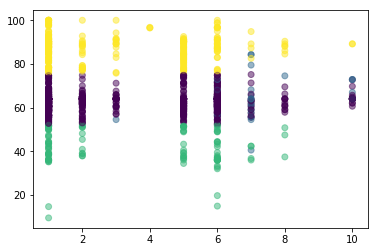

In [67]:
xAxis = testDF["q6_4"]
yAxis = testDF["q10_grade"]
cluster = testDF["cluster"]
plt.scatter(xAxis, yAxis, c=cluster, alpha=0.5)

In [ ]:
plt.scatter(xAxis, yAxis, c=cluster, alpha=0.5)

In [ ]:
testDF.to_csv("../dataset/result_cluster.csv")

## Decision Tree

In [73]:
from sklearn import datasets, tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from pandas.compat import StringIO
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [78]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [74]:
def decisionTreeRegressor(dataName, features, label):
    from sklearn import datasets, tree
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import r2_score
    from sklearn.linear_model import LinearRegression
    from pandas.compat import StringIO
    from sklearn.tree import DecisionTreeClassifier, export_graphviz
    
    trainingData_features = dataName[dataName.index%4 != 0][features]
    trainingData_label = dataName[dataName.index%4 != 0][label]
    testData_features = dataName[dataName.index%4 == 0][features]
    testData_label = dataName[dataName.index%4 == 0]

    model_method = tree.DecisionTreeRegressor()
    model = model_method.fit(trainingData_features, trainingData_label)
    decisionTreeRegressor = model.predict(testData_features)

    decisionTreeRegressor = pd.DataFrame(decisionTreeRegressor)
    decisionTreeRegressor.columns = ["PREDICT"]
    decisionTreeRegressorResult = pd.concat([testData_label.reset_index(drop=True), decisionTreeRegressor], axis=1)

    print("MAE : {:.2f}".format(mean_absolute_error(testData_label.reset_index()[label], decisionTreeRegressorResult["PREDICT"])))
    print("MSE : {:.2f}".format(mean_squared_error(testData_label.reset_index()[label], decisionTreeRegressorResult["PREDICT"])))
    print("RMSE : {:.2f}".format(math.sqrt(mean_squared_error(testData_label.reset_index()[label], decisionTreeRegressorResult["PREDICT"]))))
    print("R2 : {:.2f}".format(r2_score(testData_label[label], decisionTreeRegressorResult['PREDICT'])))

    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data, 
                    rounded=True,
                    feature_names = features,
                    filled=True,
                    impurity=False,
                    node_ids=True,
                    proportion=True,
                    special_characters=False)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

In [80]:
# feature 값을 지정
# job_group 직업분류 1.학생 2.직장인 3.무직 4.군인 999.기타
# q1 당일/숙박여행여부
# q3 여행목적
# q4_a, q4_b, q4_c 정보획득지
# q6_3_a, q6_3_b, q6_3_a 여행지 선택이유
# q7_grade 소비등급
# q8 사전예약여부
# q10_grade 만족도


In [81]:
### 특성정보 분리
# "q1", #당일/숙박여행 여부
# "q3", #여행 주 목적
# "q4_a", #정보획득지
# "q5_1", #여행 일행수
# "q8", #사전예약
# "sex",
# "job_group",
# "q7_grade",
# "q6_3_a", #여행지 선택이유
# "q6_3_b",
# "q6_3_c",
# "q6_4" # 주요 이동수단

In [93]:
features = ["q4_a"]
label = ["q10_grade"]

MAE : 9.49
MSE : 172.36
RMSE : 13.13
R2 : -0.01


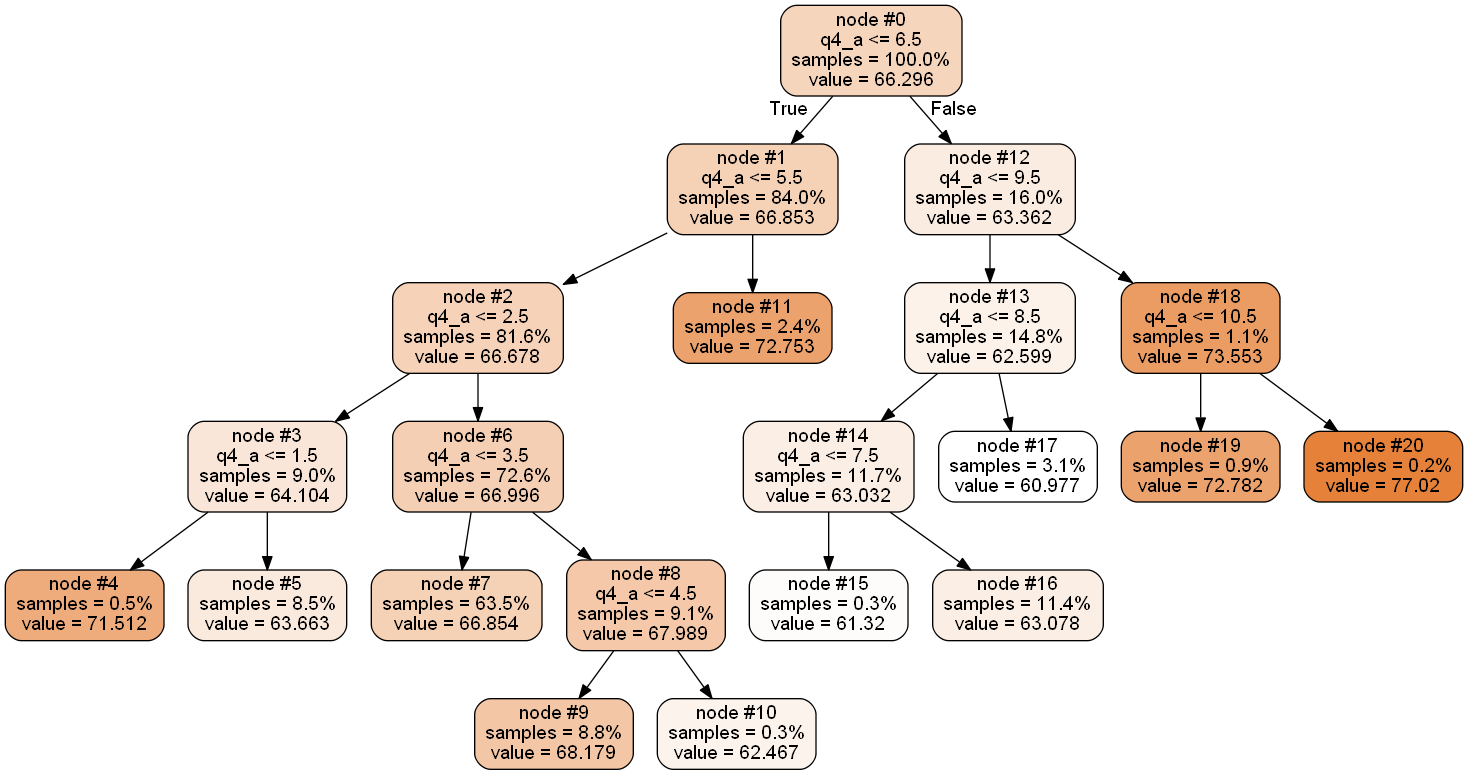

In [94]:
decisionTreeRegressor(testDF, features, label)

In [95]:
dot_data

NameError: name 'dot_data' is not defined

### 1-1. 학생 그룹

In [ ]:
studentDF = testDF[testDF["job_group"] == 1]

In [ ]:
decisionTreeRegressor(studentDF,features,label)

### 1-2. 직장인 그룹

In [ ]:
workerDF = testDF[testDF["job_group"] == 2]

In [ ]:
decisionTreeRegressor(workerDF,features,label)

### 연습장

In [ ]:
# 만족도 65이상의 데이터만 필터
filter = 65

targetDF = testDF[testDF["q10_grade"] > filter]

In [ ]:
groupKey = ["job_group","cluster","q7_grade"]

In [ ]:
tmp = testDF.groupby(groupKey).mean()[["q10_grade"]]

In [ ]:
tmp

In [ ]:
tmp2 = targetDF.groupby(groupKey).count()[["q6_6_1","q6_6_2","q6_6_3","q6_6_4","q6_6_5","q6_6_6","q6_6_7","q6_6_8","q6_6_9","q6_6_10"
                                            ,"q6_6_11","q6_6_12","q6_6_13","q6_6_14","q6_6_15","q6_6_16","q6_6_17","q6_6_18","q6_6_19","q6_6_20"
                                            ,"q6_6_21"]]

In [ ]:
tmp2.columns = ["자연/풍경 감상","음식관광","야외 위락 및 스포츠활동","역사유적지","테마파크","휴식/휴양","온천/스파","쇼핑",
                "지역문화예술/공연/전시시설","스포츠관람","지역 축제","교육/체험프로그램","종교/성지순례","갬블링","시티투어",
                "드라마 촬영지","가족/친지/친구 방문","회의참가/시찰","교육/훈련/연수","유흥/오락","기타"]

In [ ]:
#여행지 활동
tmp2

In [ ]:
tmp3 = targetDF.groupby(groupKey).count()[["q6_5_1","q6_5_2","q6_5_3","q6_5_4","q6_5_5","q6_5_6","q6_5_7",
                                          "q6_5_8","q6_5_9","q6_5_10","q6_5_11","q6_5_12","q6_5_13"]]

In [ ]:
# 숙박시설
tmp3.columns = ["숙박X","호텔","콘도","유스호스텔","모텔/여관","펜션","민박","야영","자연휴양림","가족/친지집",
                "연수원/수련원","전통한옥","기타"]

In [ ]:
tmp3

In [ ]:
tmp4 = targetDF.groupby(groupKey).count()[["q6_3_a","q6_3_b","q6_3_c"]]

In [ ]:
# 여행지 선택이유
tmp3.columns = ["숙박X","호텔","콘도","유스호스텔","모텔/여관","펜션","민박","야영","자연휴양림","가족/친지집",
                "연수원/수련원","전통한옥","기타"]

In [ ]:
testDF["q6_3_b"] = testDF["q6_3_b"].fillna(0)
testDF["q6_3_c"] = testDF["q6_3_c"].fillna(0)

In [ ]:
tempList0000 = []

for i in range(0,len(testDF)):
    tempList2222 = []
    
    q6_3_1 = testDF.loc[i,"q6_3_a"]
    q6_3_2 = testDF.loc[i,"q6_3_b"]
    q6_3_3 = testDF.loc[i,"q6_3_c"]
    
    for j in range(0,15):
        if (q6_3_1 == j):
            tempList2222.append(q6_3_1)
        elif (q6_3_2 == j):
            tempList2222.append(q6_3_2)
        elif (q6_3_3 == j):
            tempList2222.append(q6_3_3)  
        else:
            tempList2222.append(0)
    tempList0000.append(tempList2222)

In [ ]:
tempDF = pd.DataFrame(tempList0000)
tempDF.columns = ["q6_3 : 지명도","q6_3 : 볼거리","q6_3 : 여행경비","q6_3 : 이동거리","q6_3 : 시간","q6_3 : 숙박시설","q6_3 : 동반자 유형",
          "q6_3 : 쇼핑","q6_3 : 음식","q6_3 : 교통편","q6_3 : 체험프로그램","q6_3 : 경험자 추천","q6_3 : 관광지 편의시설",
           "q6_3 : 교육성","q6_3 : 기타"]
# result01 = pd.concat([testDF, tempList0000], axis=1)

In [ ]:
testDF["q4_b"] = testDF["q4_b"].fillna(0)

In [ ]:
tempList0000 = []

for i in range(0,len(testDF)):
    tempList2222 = []
    
    q4_a = testDF.loc[i,"q4_a"]
    q4_b = testDF.loc[i,"q4_b"]
    
    for j in range(0,11):
        if (q4_a == j):
            tempList2222.append(q4_a)
        elif (q4_b == j):
            tempList2222.append(q4_b) 
        else:
            tempList2222.append(0)
    tempList0000.append(tempList2222)

In [ ]:
tempDF = pd.DataFrame(tempList0000)
tempDF.columns = ["q4_ab : 여행사","q4_ab : 가족/친지","q4_ab : 친구/동료","q4_ab : 인터넷","q4_ab : 관광서적","q4_ab : 기사/방송",
                 "q4_ab : 광고","q4_ab : 과거경험","q4_ab : 모바일앱","q4_ab : 기타","q4_ab : 없음"]
# result01 = pd.concat([testDF, tempList0000], axis=1)